In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import contextily as ctx
import cpi
import pandas as pd
from datetime import date
from shapely.geometry import Point

In [2]:
cpi.update()  # this takes forever for some reason

# Analysis 1: Kalihiwai vicinity prop values

In [4]:
huliaina = gpd.read_file("./datasets/kalihiwai_kalihikai_anini_shp.zip", crs="EPSG:26904").to_crs("EPSG:4326")
huliaina = huliaina.replace(0, np.nan)

corelogic = gpd.read_file("./datasets/corelogic_with_tmk.csv")
corelogic["TMK"] = corelogic.TMK.astype(int)
corelogic["MKT_TOTAL_VALUE"][corelogic["MKT_TOTAL_VALUE"] == ""] = "nan"
corelogic["MKT_TOTAL_VALUE"] = corelogic["MKT_TOTAL_VALUE"].astype(float)

/var/folders/dm/y4ghq6t940n1__g5lvs8g6tr0000gn/T/ipykernel_58397/1934474875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corelogic["MKT_TOTAL_VALUE"][corelogic["MKT_TOTAL_VALUE"] == ""] = "nan"


In [5]:
# grab the properties under 5 acres
maxacres = 5
small = huliaina[huliaina["TAXACRES"] < maxacres]

# set up years of interest
years = sorted([
    '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2005', '1990',
    '1985', '1980', '1975', '1970', '1965',
])

# adjust for inflation
inflated = small.copy(deep=True)
inflation_base = date(2018, 1, 1)
for year in years:
    inflated[year] = inflated[year].apply(lambda x: cpi.inflate(x, date(int(year), 1, 1), to=inflation_base))

# calculate the mean property value for each year (for properties with data)
mean_value = []
for year in years:
    mean_value.append(inflated[year].mean())  # mean disregards nans

In [6]:
matching_corelogic = corelogic[corelogic.TMK.isin(inflated["TMK"])]
corelogic_2019_mean = cpi.inflate(matching_corelogic.MKT_TOTAL_VALUE.mean(), date(2019, 1, 1), to=inflation_base)

/Users/dklink/opt/miniconda3/envs/kauai/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 14 is not valid for the current tile provider (valid zooms: 0 - 13).
  warnings.warn(msg)


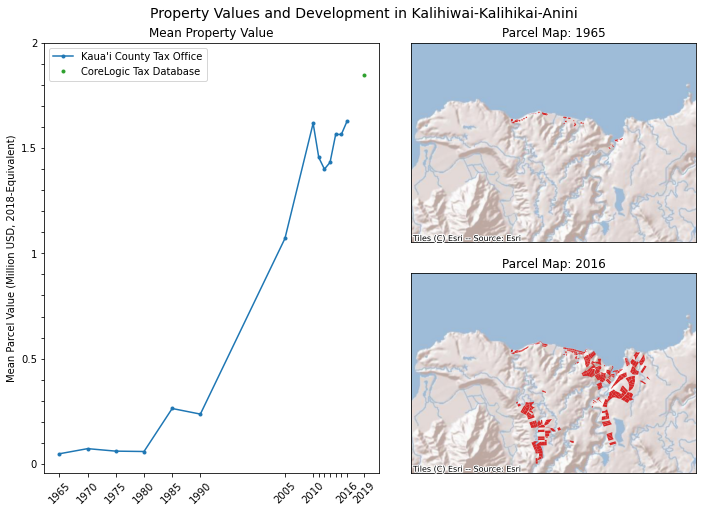

In [8]:
# this plots the huliaina parcels within a basemap
%matplotlib inline
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(10, 7), constrained_layout=True)
ax0 = axd["upper right"]
ax1 = axd["lower right"]
ax2 = axd["left"]

inflated[~inflated[years[0]].isnull()].plot(ax=ax0, color="tab:red")
inflated[~inflated[years[-1]].isnull()].plot(ax=ax1, color="tab:red")

for ax in [ax0, ax1]:
    ax.set_xlim([-159.5, -159.4])
    ax.set_ylim([22.18, 22.25])
    ax.set_xticks([])
    ax.set_yticks([])

x = [int(y) for y in years]
ax2.plot(x, np.array(mean_value)/1e6, ".-", color="tab:blue", label="Kaua'i County Tax Office")
ax2.plot(2019, corelogic_2019_mean/1e6, '.', color="tab:green", label="CoreLogic Tax Database")
xlabel_years = [1965, 1970, 1975, 1980, 1985, 1990, 2005, 2010, "", "", "", "", "", 2016, 2019]
ax2.set_xticks(x + [2019])
ax2.set_xticklabels(xlabel_years, rotation=45)
ax2.set_ylabel(f"Mean Parcel Value (Million USD, {inflation_base.year}-Equivalent)")
ax2.set_yticks(np.arange(0, 2.1, .1))
ax2.set_yticklabels([0, "", "", "", "", .5, "", "", "", "", 1, "", "", "", "", 1.5, "", "", "", "", 2])
ax2.set_title(f"Mean Property Value")
ax2.legend()
ax0.set_title(f"Parcel Map: {years[0]}")
ax1.set_title(f"Parcel Map: {years[-1]}")
plt.autoscale(False)

ctx.add_basemap(ax0, crs = huliaina.crs, source = ctx.providers.Esri.WorldShadedRelief)
ctx.add_basemap(ax1, crs = huliaina.crs, source = ctx.providers.Esri.WorldShadedRelief)

plt.suptitle("Property Values and Development in Kalihiwai-Kalihikai-Anini", fontsize=14)

plt.savefig("./final_figures/Kalihiwai-Kalihikai-Anini.png", dpi=200, facecolor="white")